#  Created by Joshua McCready (jmccread@umich.edu/jmccrea8@ford.com)
## Naive Bayes Model for Binary Road Wheel Misalgingment Classification

Perform feature selection by iteratively removing features according to thier mutual information score for k-folds cross validation over the numeric features present in the dataset. As a part of the k-folds validation features are recursively eliminated based on feature rank until average training model performance suffers by at least 2% or until features run out.

In [23]:
import numpy as np
import math
import os
from os.path import isfile, join
from os import walk
from pathlib import Path
import pandas as pd
import time
import scipy.io as sio
import matplotlib.pyplot as plt
import itertools  


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import util.reports as rp

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE
from sklearn.metrics import mutual_info_score

import sys
sys.path.append('../') # Feeling cute might delete later
from util.reports import report_feature_ranking
from util.fspp import get_fspp
from util.mutual import MutualInfo
from util.reports import report_feature_ranking

import seaborn as sn
import pickle

## Import data from hard drive

In [24]:
root = r".\..\Data" 
file = os.path.join(root, "df_cat_5Hz.pkl")
df_cat = pd.read_pickle(file)
file = os.path.join(root, "df_num_5Hz.pkl")
df_num = pd.read_pickle(file)
file = os.path.join(root, "df_out_5Hz.pkl")
df_out = pd.read_pickle(file)

## Remove unneeded features on the basis of feature to feature correlation and low mutual information
|Correlation| > 0.98 against another feature: ["Front Right Wheel Speed", "Front Left Wheel Speed", "Rear Right Wheel Speed", "Rear Left Wheel Speed", "Vehicle Yaw Rate"]

low mutual information: ['Total Brake Torque', 'Vehicle Lateral Acceleration', 'Accelerator Pedal Position Percent Rate']

In [25]:
featureNames = df_num.columns # replace with actual list of things
toDrop = ["Front Right Wheel Speed", "Front Left Wheel Speed", "Rear Right Wheel Speed", "Rear Left Wheel Speed", "Vehicle Yaw Rate", 'Total Brake Torque', 'Vehicle Lateral Acceleration', 'Accelerator Pedal Position Percent Rate']
remove = [featureNames.get_loc(label) for label in toDrop]
allFeatures = [df_num.columns.get_loc(label) for label in featureNames]
features = list(set(allFeatures) - set(remove))

## Create X and y, divide train/test, and define model + pipeline

In [26]:
X_full = df_num.iloc[:, features].values
X_labels = df_num.iloc[:, features].columns
# Create binary classifier all postive class are one kind of misalginement or another
y_full = df_out.iloc[:, 3].values >0

# Does Train/test split
X, X_holdout, y, y_holdout = train_test_split(X_full, y_full, test_size = 0.20, random_state = 0)
# Defines model
mdl = GaussianNB()
sc = StandardScaler()
# Setup pipeline to perform cross validation 
estimators = [('normalizer', sc), ('classifier', mdl)]
pipe = Pipeline(estimators)

In [27]:
#resultsLst = list()
bestPipeL = list() 
trainPerfL = list()
validPerfL = list()
featuresL = list()

## Setup recursive feature elimination with K folds validation

In [28]:
def featurePrinter(feat_inds, df_X): 
    print("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")
    print("Mutual information recursive feature elimination, using ", '%d' % len(feat_inds), "features")
    #removed = np.asarray(list(set(feat_inds) - set(red_feat_inds)))
    #print("Features being removed: ")
    #print(df_X.iloc[:, removed].columns)
    print("Features being used: ")
    print(df_X.iloc[:, feat_inds].columns)
    print("----------------------------------------------------------------------------------------------")
    
def resultsPrinter(prevResults, results, end, start, tol):
    print('Elpased time:', end-start, " seconds")
    print("Decison: results['train_f1'].mean(): ", '%.3f' % (results['train_f1'].mean()), ", against threshold: ", '%.3f' % (prevResults['train_f1'].mean() - tol))
    print("----------------------------------------------------------------------------------------------")
    print('\nTraining Metrics: ')
    print('Accuracy (Avg): ', '%.2f' % results['train_accuracy'].mean())
    print('F1 Macro (Avg): ', '%.2f' % results['train_f1'].mean())
    print('Recall Macro (Avg): ', '%.2f' % results['train_recall'].mean())
    print('Precision Macro (Avg): ', '%.2f' % results['train_precision'].mean())
    print('\nTime training (Avg): ', results['fit_time'].mean())
    print('\nValidation Metrics: ')
    print('Accuracy (Avg): ', '%.2f' % results['test_accuracy'].mean())
    print('F1 Macro (Avg): ', '%.2f' % results['test_f1'].mean())
    print('Recall Macro (Avg): ', '%.2f' % results['test_recall'].mean())
    print('Precision Macro (Avg): ', '%.2f' % results['test_precision'].mean(), "\n")
    print("----------------------------------------------------------------------------------------------")
    
def removedPrinter(feat_inds, red_feat_inds, df_X): 
    removed = np.asarray(list(set(feat_inds) - set(red_feat_inds)))
    print("Features being removed: ")
    print(df_X.iloc[:, removed].columns)
    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    print("\n")
    

In [29]:
# Utility function to perform recursive feature reduction of k features with cross validation
def RFE_MI(df_X, y, pipe, feat_inds, bestPipeLst, trainPerfLst, validPerfLst, featuresLst,  k=2, numSplt=3, prevResults=-1, verbose=1):
    
    start = time.perf_counter()
    X = df_X.iloc[:, feat_inds].values # Select the features we want based on previous
    kf = KFold(n_splits = numSplt, random_state = 0,  shuffle=True)
    
    # Perform Model Selection  #################################################################################
        # Cross validate with model settings ###################################################################
    results = cross_validate(pipe, X, y, cv=kf, scoring=['accuracy', 'f1','precision','recall'], n_jobs=-1, return_estimator=True, return_train_score=True)
    best_index  = results['train_f1'].argmax()
    bestPipe = results['estimator'][best_index]
    #resultsLst.append(results)
    featuresLst.append(feat_inds)
    bestPipeLst.append(bestPipe) 
    trainPerfLst.append([results['train_accuracy'][best_index], results['train_f1'][best_index],
                         results['train_recall'][best_index], results['train_precision'][best_index]]) 
    validPerfLst.append([results['test_accuracy'][best_index], results['test_f1'][best_index],
                         results['test_recall'][best_index], results['test_precision'][best_index]]) 
    n = X.shape[1]-k # keep n features 
    tol = 0.02
    
    # Perform feature selection ###########################################################################
        # for each train fold, test mutual information - maybe delete and do "best" pick
    rank = np.zeros(X.shape[1])
    inds_red = []
    i = 0
    for train_index, test_index in kf.split(X):
        if i == best_index:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            mi = MutualInfo(X_train, y_train, 2, n_jobs=-1)
            rank = mi.compute()
            inds_red = np.argpartition(rank, -n)[-n:] # gets n largest elements from mi.compute
        i = i+1 
    # Eliminate Features  #####################################################################################      
    #inds_red = np.argpartition(ind_counts, -n)[-n:] # gets n largest elements from ind_counts
    feat_inds_red = feat_inds[inds_red] 
    
    # Recursive Step  ######################################################################################### 
    if prevResults == -1:
        prevResults = results
    if results['train_f1'].mean() < (prevResults['train_f1'].mean() - tol):
        end = time.perf_counter()
        if verbose:
            print("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")
            print('Elpased time:', end-start, " seconds")
            print("Stop condition reached, model got worse, returning previous results")
            print("----------------------------------------------------------------------------------------------")
            print("Final Features used: ")
            print(df_X.iloc[:, feat_inds].columns)
            print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            print("\n")
        return feat_inds, prevResults
    else:
        end = time.perf_counter()
        if verbose:
            featurePrinter(feat_inds, df_X)
            resultsPrinter(prevResults, results, end, start, tol)
            removedPrinter(feat_inds, feat_inds_red, df_X)
        if len(feat_inds) <= k:
            print("Stop condition reached, cannot remove k more features, returning previous results")
            return feat_inds, results
        else: 
            return RFE_MI(df_X, y, pipe, feat_inds_red, bestPipeLst, trainPerfLst, validPerfLst, featuresLst, k, numSplt, results, 1)

## Evaluate the RFE

In [30]:
feat_inds = np.arange(0, X.shape[1], 1)
k = 3
prevResults = -1
df_X = pd.DataFrame(X, columns=np.asarray(X_labels)) 
final_feat_inds, results = RFE_MI(df_X, y, pipe, feat_inds, bestPipeL, trainPerfL, validPerfL, featuresL,  3, 4, -1, 1)

vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Mutual information recursive feature elimination, using  24 features
Features being used: 
Index(['Lateral Acceleration Condition', 'CVC Control Error Angle Estimate',
       'CVC Filtered Offset Angle ', 'Curvature Condition',
       'Roll Angle Estimate', 'Steering Wheel Angle Condition',
       'Steering Control Module Current', 'Compensated Steering Wheel Angle',
       'Steering Column Torque', 'Vehicle Lateral Acceleration  Compensated',
       'Vehicle Longitudinal Acceleration ',
       'Vehicle Longitudinal Acceleration Compensated', 'Vehicle Roll Rate',
       'Vehicle Vertical Acceleration', 'Vehicle Yaw Rate Compensated',
       'Vehicle Speed (Engine or Brakes)', 'Vehicle Speed Condition',
       'Average Assist During Accelerating',
       'Average Assist During Decelerating', 'Average Assist Torque Long Term',
       'Average Assist Torque Short Term',
       'Pull Drift Compen

## Evaluate hold out

In [13]:
y_pred_list = list() 
holdoutPerfL = list()
df_X_holdout = pd.DataFrame(X_holdout, columns=np.asarray(X_labels)) 
len(featuresL)
for i in range(len(featuresL)):
    Bpipe = bestPipeL[i]
    feats = featuresL[i]
    X_holdout_mod = df_X_holdout.iloc[:, feats].values # reduce to right features 
    y_pred = Bpipe.predict(X_holdout_mod)
    y_pred_list.append(y_pred)
    holdoutPerfL.append([accuracy_score(y_pred,y_holdout), f1_score(y_pred,y_holdout),
                         recall_score(y_pred,y_holdout), precision_score(y_pred,y_holdout)]) 

### Plot K-folds performance

<Figure size 432x288 with 0 Axes>

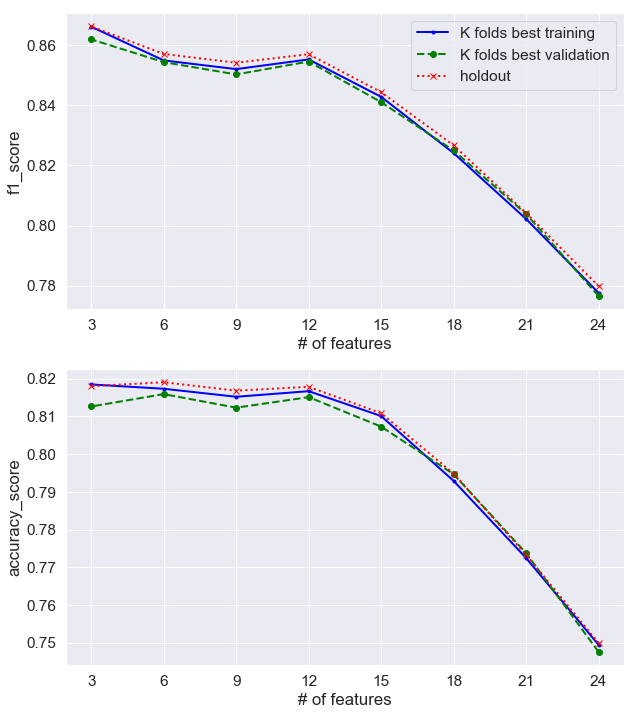

In [54]:
train = np.asarray(trainPerfL)[:,1]
valid = np.asarray(validPerfL)[:,1]
holdout = np.asarray(holdoutPerfL)[:,1]
featLens = list()
[featLens.append(len(feat)) for feat in featuresL]

perfstr = 'f1_score'
fig = plt.figure(1)
plt.subplots(figsize=(10,12))
f1 = plt.subplot(211)
plt.plot( featLens, train, marker='.',  color='blue',  linestyle='-', linewidth=2, label="K folds best training")
plt.plot( featLens, valid, marker='o', color='green', linewidth=2,  linestyle='dashed', label="K folds best validation")
plt.plot( featLens, holdout, marker='x', color='red', linewidth=2, linestyle=':', label="holdout")
plt.ylabel(perfstr)
plt.xlabel('# of features')
plt.legend()
plt.show
plt.axis('auto')
plt.xticks(np.arange(min(featLens), max(featLens)+1, step=k))
#plt.savefig('f1_naive_bayes.png')

train = np.asarray(trainPerfL)[:,0]
valid = np.asarray(validPerfL)[:,0]
holdout = np.asarray(holdoutPerfL)[:,0]
perfstr = 'accuracy_score'
f1 = plt.subplot(212)
plt.plot( featLens, train, marker='.',  color='blue',  linestyle='-', linewidth=2, label="K folds best training")
plt.plot( featLens, valid, marker='o', color='green', linewidth=2,  linestyle='dashed', label="K folds best validation")
plt.plot( featLens, holdout, marker='x', color='red', linewidth=2, linestyle=':', label="holdout")
plt.ylabel(perfstr)
plt.xlabel('# of features')
#plt.legend()
plt.show
plt.axis('auto')
plt.xticks(np.arange(min(featLens), max(featLens)+1, step=k))
root = r".\results" 
file = os.path.join(root, 'BayesianPerf.png')
fig.savefig(file)

## Print performance in the holdout dataset against the best model (with 9 features)

In [58]:
best = featLens.index(3) # seems to satisfy the heuristic of low number of features, high f1 and accuracy 
Bpipe = bestPipeL[best]
feats = featuresL[best]
y_pred = y_pred_list[best]
print("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")
print('Holdout Test Metrics: ')
print("----------------------------------------------------------------------------------------------")
print('Accuracy: ', '%.2f' % accuracy_score(y_pred,y_holdout))
print('F1 Score: ', '%.2f' % f1_score(y_pred,y_holdout))
print('Recall: ', '%.2f' % recall_score(y_pred,y_holdout))
print('Precision: ', '%.2f' % precision_score(y_pred,y_holdout))
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Holdout Test Metrics: 
----------------------------------------------------------------------------------------------
Accuracy:  0.82
F1 Score:  0.87
Recall:  0.83
Precision:  0.90
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[Text(26.5,0.5,'Output Class'), Text(0.5,8.5,'Target Class')]

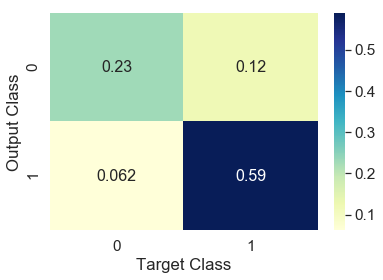

In [59]:
# Making the Confusion Matrix
cm = confusion_matrix(y_holdout, y_pred)
cm_normal = cm/len(y_pred)
sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(cm_normal,  cmap="YlGnBu", annot=True,annot_kws={"size": 16})# font size
ax.set(xlabel='Target Class', ylabel='Output Class')

In [13]:
filename = r".\results\final_naive_bayes" 
pickle.dump(Bpipe, open(filename, 'wb'))
#NB_best = pickle.load(open(filename, 'rb'))
#type(NB_best)